In [36]:
from genesis.version4 import Genesis4
from genesis import tools
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.constants as sp_const
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.plot import density_and_slice_plot, slice_plot

%config InlineBackend.figure_format = 'retina' # Nicer plot


 # Read in particle file made from PyTao Simulations

To create a file at the end of the PyTao simulation add, 

PFILE02 = './linac/Tao_output.h5'
P1.write(PFILE02)

Otherswise this notebook can be added to the cu_inj_linac srit

In [37]:
PFILE0 = './linac/Tao_output.h5'
P1 = ParticleGroup(PFILE0)
NSAMPLE = len(P1)
P1 = P1.resample(NSAMPLE)

twiss_match = True
alpha_x0 = -0.7393217413918415 
beta_x0 = 7.910909406464387
alpha_y0 = 1.3870723536888105 
beta_y0 = 16.8811786213468987

# Change to s-coordinates (different times t, constant z)
P1.drift_to_z() # drift to P['mean_z']

#t_ref=0
# Zero out the mean time
#P1.t += t_ref -P1['mean_t']

if twiss_match:
    P1.twiss_match(beta =  beta_x0  , alpha =alpha_x0, plane = 'x', inplace = True)
    P1.twiss_match(beta =  beta_y0  , alpha =alpha_y0, plane = 'y', inplace = True)


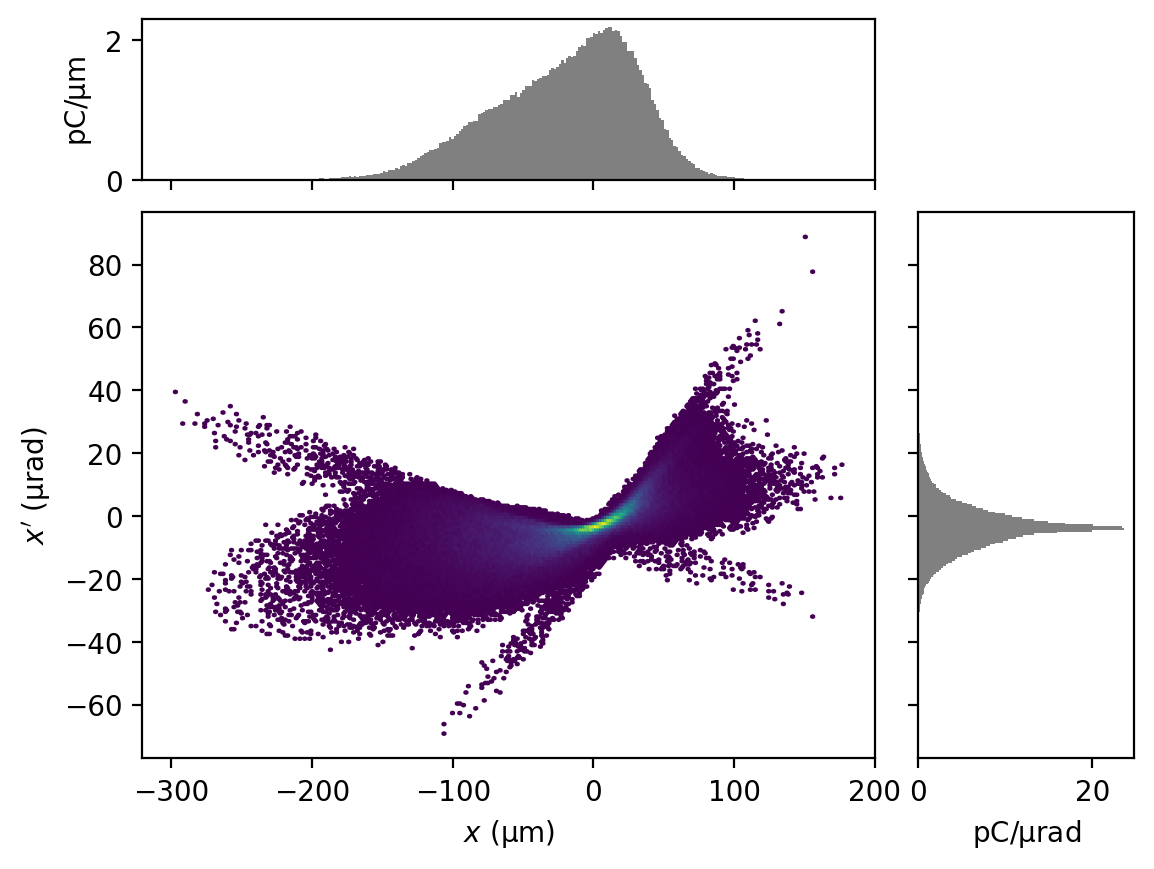

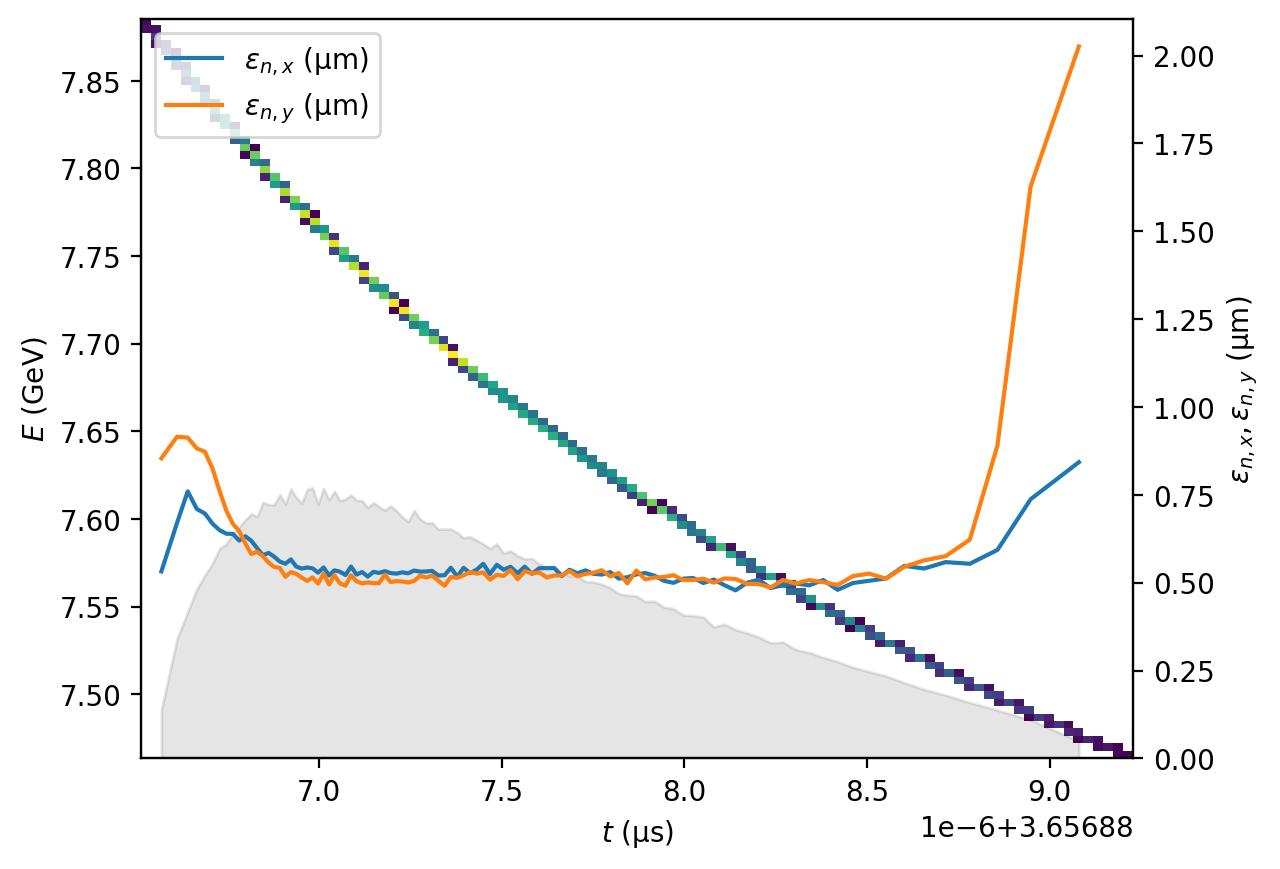

In [38]:
#Lets check we have the right beam
P1.plot('x', 'xp')
density_and_slice_plot(P1, 't', 'energy', stat_keys = ['norm_emit_x', 'norm_emit_y'], n_slice = 100, bins=100)
#plt.xlim(4.175, 4.2)

# Genisis simulation

In [39]:
# Get the relevant files and directories
run_file_location=os.path.expandvars('$LCLS_LATTICE/genesis/version4/cu_hxr/')
run_file=os.path.expandvars('cu_hxr.in')
workdir=os.path.expandvars('$SCRATCH')

G = Genesis4(run_file_location + run_file, workdir=workdir, verbose = True)

Configured to run in: /sdf/scratch/users/j/jmorgan/tmpgyvigyno


In [40]:
nproc=180
G.nproc = nproc
# here we can make changes to the input files for this simulatin run in scratch
gamma=15032.319235694877
G.input['main'][0]['gamma0'] = gamma # if we need to change gamma0
G.input['main'].append({'type': 'write', 'beam': 'end'})  # this writes out the particles at the ened of the simulation

# Now use the partilce data, this will right the particles in the file format the Genesis expects. 
G.initial_particles = P1

G.write_input(path=G.path, input_filename=run_file)

Initial particles written to /sdf/scratch/users/j/jmorgan/tmpgyvigyno/genesis4_importdistribution.h5
Updated slen = 0.0008145097838035091
Removed 'beam' from input, will be replaced by 'importdistribution'
Added new importdistribution before the first track
Setting use_mpi = True because nproc = 180


In [41]:
# we are ready to run genesis
G.write_input(path=G.path, input_filename=run_file)
runscript = "salloc --partition milano --account ad:beamphysics --mem-per-cpu=4g  -n {nproc} mpirun -n {nproc} {command_mpi} {inputfile}".format(nproc = G.nproc, command_mpi = G.command_mpi, inputfile = G.path + '/' + run_file)
log = []
for path in tools.execute(runscript.split(), cwd=G.path):
    G.vprint(path, end="")
    log.append(path)
G.vprint("Finished.")

Initial particles written to /sdf/scratch/users/j/jmorgan/tmpgyvigyno/genesis4_importdistribution.h5
Updated slen = 0.0008145097838035091
Updated existing importdistribution


salloc: Pending job allocation 43594655
salloc: job 43594655 queued and waiting for resources
salloc: job 43594655 has been allocated resources
salloc: Granted job allocation 43594655
salloc: Waiting for resource configuration
salloc: Nodes sdfmilan[038-039,215-220] are ready for job


---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by conda at 2024-01-11 18:02:26 [UTC] from Git Commit ID: 226c27d5b1b045a8195218d2ce5d63aaa10537c7
Starting Time: Thu Apr 11 16:04:52 2024

MPI-Comm Size: 180 nodes

Opened input file /sdf/scratch/users/j/jmorgan/tmpgyvigyno/cu_hxr.in
Parsing lattice file hxr.lat ...
Setting up time window of 819.081 microns with 29700 sample points...
Generating input radiation field for HARM = 1 ...
Adding profile with label: beamcurrent
Adding profile with label: beamgamma
Importing distribution file... 
Charge of external distribution: 2.5e-10
Particles in external distribution: 300000
Analysing external distribution... 
Analysis of the imported distribution
   Total Bunch Length  (microns): 814.51
*** Non-matching PArticle Transfar: Rank: 6 Deleted: 1662 Forward: 1662 Backward: 7
*** Non-matching PArticle Transfar: Rank: 7 Deleted: 1664 Forward: 1660 Backward: 7
*** Non-matching PArticle Tra

salloc: Relinquishing job allocation 43594655
salloc: Job allocation 43594655 has been revoked.


Loading main output: /sdf/scratch/users/j/jmorgan/tmpgyvigyno/LCLS2_HXR_9keV.out.h5


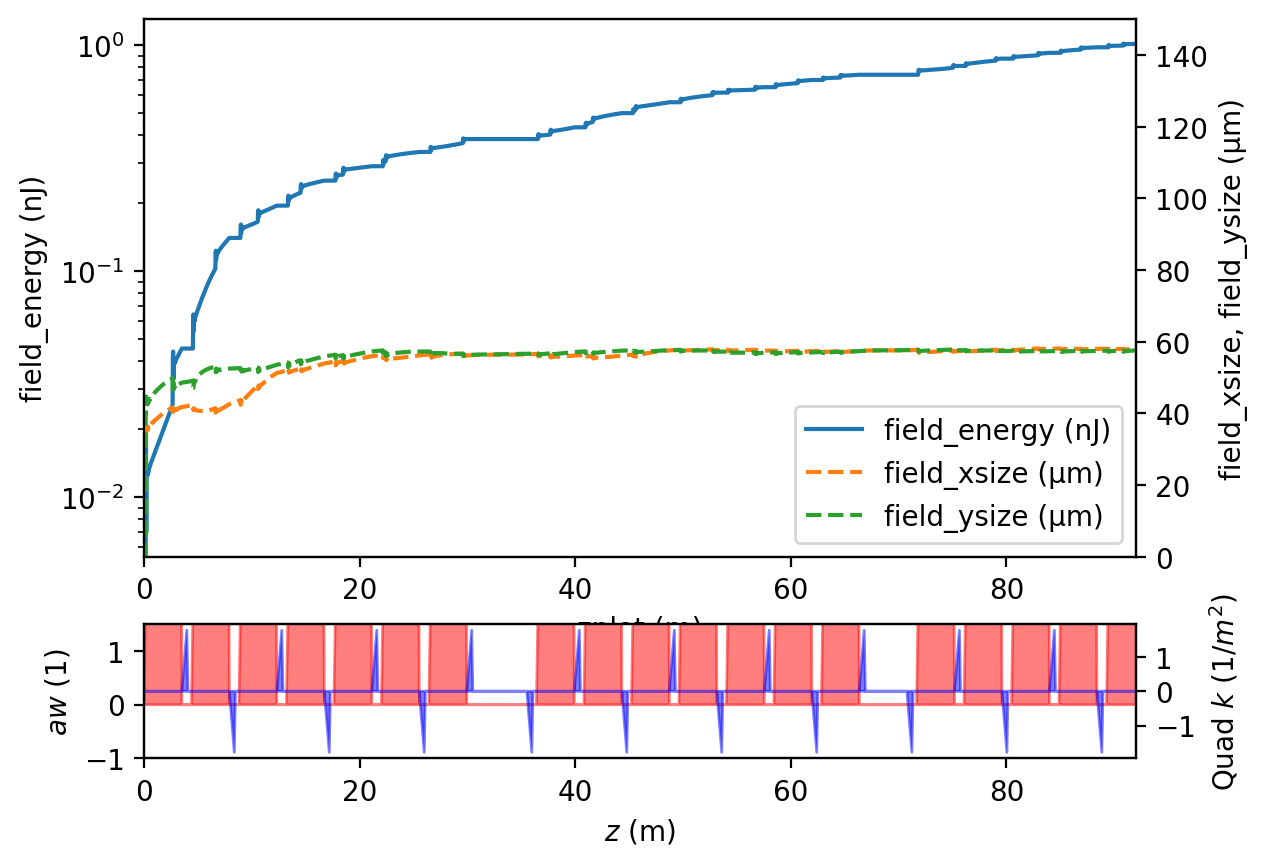

In [42]:
G.log = log
G.load_output()
G.plot('field_energy', yscale='log', y2 = ['field_xsize', 'field_ysize'], ylim2=(0e-6, 150e-6))

Loaded particle data: 'end' as a ParticleGroup with 30394368 particles


<ParticleGroup with 30394368 particles at 0x7fe85c1d8ac0>

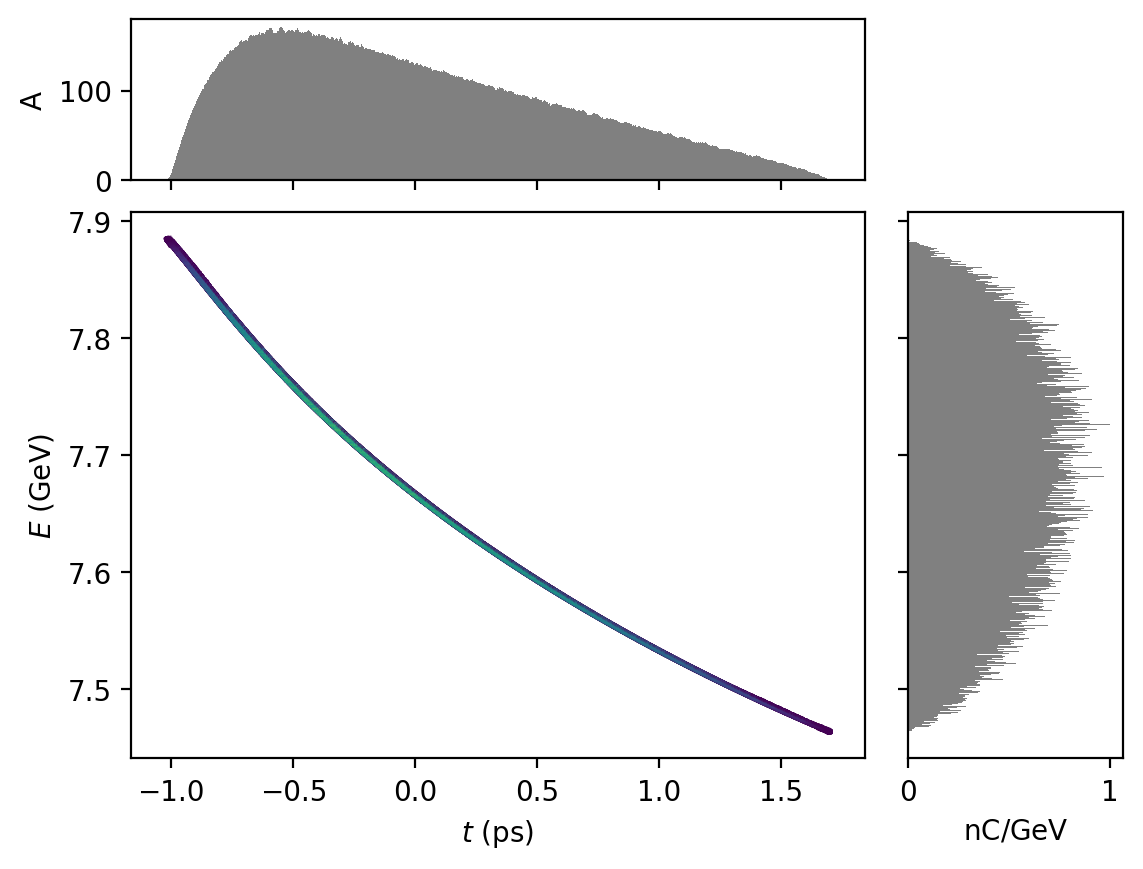

In [43]:
G.load_particles()
P1 = G.particles['end']
P1.drift_to_z()
P1.plot('t', 'energy')
P1